In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, Ridge

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
# read California housing prices
df = pd.read_csv('data/housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
selected_columns = [
    'longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'
]

### Data preparation

In [4]:
df = df[selected_columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [6]:
# impute with cero
df['total_bedrooms'] = df['total_bedrooms'].fillna(0)
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [7]:
# new columns
df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
df['population_per_household'] = df['population'] / df['households']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 20640 non-null  float64
 1   latitude                  20640 non-null  float64
 2   housing_median_age        20640 non-null  float64
 3   total_rooms               20640 non-null  float64
 4   total_bedrooms            20640 non-null  float64
 5   population                20640 non-null  float64
 6   households                20640 non-null  float64
 7   median_income             20640 non-null  float64
 8   median_house_value        20640 non-null  float64
 9   ocean_proximity           20640 non-null  object 
 10  rooms_per_household       20640 non-null  float64
 11  bedrooms_per_room         20640 non-null  float64
 12  population_per_household  20640 non-null  float64
dtypes: float64(12), object(1)
memory usage: 2.0+ MB


### Q1: What is the most frequent observation (mode) for the column ocean_proximity?

In [8]:
df.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

### Q3: What are the two features that have the biggest correlation in this dataset?

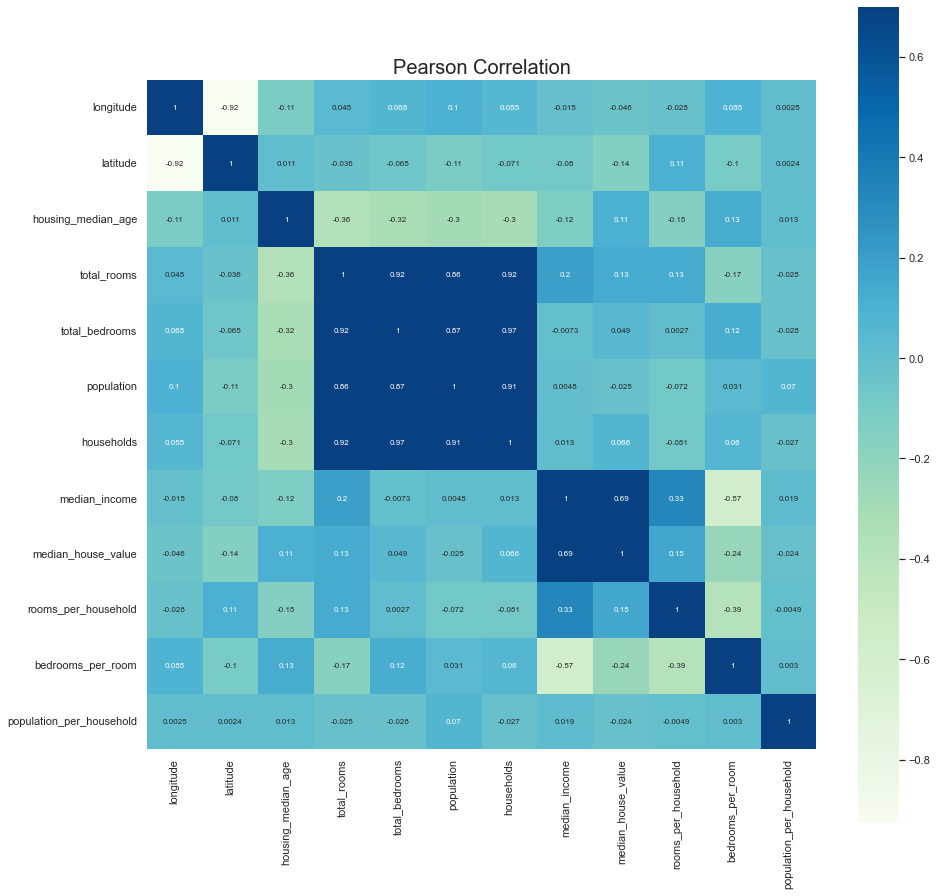

In [9]:
# Pearson
sns.set(style="whitegrid", font_scale=1)
plt.figure(figsize=(15, 15))
plt.title("Pearson Correlation", fontsize=20)
sns.heatmap(df.corr(), vmax=0.7, square=True, cmap="GnBu", linecolor="b", annot=True, annot_kws={"size":8});

In [10]:
med_hval_mean = round(df['median_house_value'].mean(), 2)
med_hval_mean

206855.82

In [11]:
# create above_average column
df['above_average'] = df['median_house_value'].apply(lambda x: 1 if med_hval_mean > x else 0)
df['above_average'].value_counts()

1    12255
0     8385
Name: above_average, dtype: int64

In [12]:
# split the data
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [13]:
len(df_train), len(df_val), len(df_test)

(12384, 4128, 4128)

In [14]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [15]:
y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

df_train = df_train.drop(['median_house_value', 'above_average'], axis=1)
df_val = df_val.drop(['median_house_value', 'above_average'], axis=1)
df_test = df_test.drop(['median_house_value', 'above_average'], axis=1)

In [16]:
df_full_train = df_full_train.reset_index(drop=True)

In [17]:
df_full_train.isnull().sum()

longitude                   0
latitude                    0
housing_median_age          0
total_rooms                 0
total_bedrooms              0
population                  0
households                  0
median_income               0
median_house_value          0
ocean_proximity             0
rooms_per_household         0
bedrooms_per_room           0
population_per_household    0
above_average               0
dtype: int64

In [18]:
df_full_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 16512 non-null  float64
 1   latitude                  16512 non-null  float64
 2   housing_median_age        16512 non-null  float64
 3   total_rooms               16512 non-null  float64
 4   total_bedrooms            16512 non-null  float64
 5   population                16512 non-null  float64
 6   households                16512 non-null  float64
 7   median_income             16512 non-null  float64
 8   median_house_value        16512 non-null  float64
 9   ocean_proximity           16512 non-null  object 
 10  rooms_per_household       16512 non-null  float64
 11  bedrooms_per_room         16512 non-null  float64
 12  population_per_household  16512 non-null  float64
 13  above_average             16512 non-null  int64  
dtypes: flo

### Q3: What is the value of mutual information?

In [19]:
round(mutual_info_score(df_full_train.above_average, df_full_train.ocean_proximity), 2)

0.1

### Q4: Accuracy of the model

In [20]:
# one-hot enconding
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [21]:
X_train.shape, X_val.shape, y_train.shape

((12384, 16), (4128, 16), (12384,))

In [22]:
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [23]:
y_pred = model.predict_proba(X_val)[:, 1]
house_val_pred = (y_pred >= 0.5)

In [24]:
(y_val == house_val_pred).mean().round(2)

0.84

### Q5:  Feature selection - the smallest difference in accuracy

In [25]:
df_train.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'rooms_per_household', 'bedrooms_per_room',
       'population_per_household'],
      dtype='object')

In [26]:
tot_score = []

for col in df_train.columns:
    df_train1 = df_train.drop(col, axis=1)
    df_val1 = df_val.drop(col, axis=1)
    
    train_dict1 = df_train1.to_dict(orient='records')
    X_train1 = dv.fit_transform(train_dict1)

    val_dict1 = df_val1.to_dict(orient='records')
    X_val1 = dv.transform(val_dict1)
    
    model1 = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
    model1.fit(X_train1, y_train)
    
    y_pred1 = model1.predict_proba(X_val1)[:, 1]
    house_val_pred = (y_pred1 >= 0.5)
    
    score = (y_val == house_val_pred).mean()
    tot_score.append(score)
    print(col, ", ",score)


longitude ,  0.8318798449612403
latitude ,  0.8330910852713178
housing_median_age ,  0.8321220930232558
total_rooms ,  0.8367248062015504
total_bedrooms ,  0.8357558139534884
population ,  0.8263081395348837
households ,  0.8333333333333334
median_income ,  0.7858527131782945
ocean_proximity ,  0.8192829457364341
rooms_per_household ,  0.8347868217054264
bedrooms_per_room ,  0.8362403100775194
population_per_household ,  0.8359980620155039


In [27]:
tot_score - (y_val == house_val_pred).mean()

array([-0.00411822, -0.00290698, -0.00387597,  0.00072674, -0.00024225,
       -0.00968992, -0.00266473, -0.05014535, -0.01671512, -0.00121124,
        0.00024225,  0.        ])

### Q6: Regression with Scikit-Learn. What's the best alpha?

In [28]:
# split the data
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

 # reset index in df's
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# log transformation
y_train = np.log1p(df_train.median_house_value)
y_val = np.log1p(df_val.median_house_value)
y_test = np.log1p(df_test.median_house_value)

# delete above_average variable
df_train = df_train.drop(['above_average'], axis=1)
df_val = df_val.drop(['above_average'], axis=1)
df_test = df_test.drop(['above_average'], axis=1)

# one-hot enconding
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

# rmse function
def rmse(y, y_pred): 
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [29]:
for a in [0, 0.01, 0.1, 1, 10]:
    model = Ridge(alpha=a, solver="sag", random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    score = rmse(y_val, y_pred).round(3)
    print(a, " ,", score)

0  , 0.177
0.01  , 0.177
0.1  , 0.177
1  , 0.177
10  , 0.177
